# **Fine-tuning for Image Classification of ASL with SWIN Transformer V2**



In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision).

Before we start, let's install the `datasets` and `transformers` libraries.

In [ ]:
!pip install -q datasets transformers
!pip install transformers[torch]
!pip install accelerate -U
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 6.0 MB/s eta 0:00:00


First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Importing data into Hugging Face hub and datasets (optional)

The following is how you start with raw images and upload them into Hugging Face datasets.  For this project, if you just want to start training on the indian foods dataset, you can skip this portion of the notebook.
I started by gettig the raw image data from [Kaggle](https://www.kaggle.com/datasets/l33tc0d3r/indian-food-classification?resource=download-directory).  I put the images into my Google drive and copied it over to my Google Colab instance.  You will have to change the origin folder to your location

In [ ]:
# need to executed once
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# import os
# import shutil

# original_dir_loc = '/content/drive/MyDrive/American Sign Language (ASL) dataset'
# new_output = '/content/ASL_Isolated_Swin_dataset'

# # List of main directories
# main_dirs = ['test', 'train', 'valid']

# for main_dir in main_dirs:
#     image_dir = os.path.join(original_dir_loc, main_dir, 'images')
#     print(main_dir)
#     # Check if the 'images' directory exists
#     if os.path.exists(image_dir):

#         # Loop through all files in the 'images' directory
#         for filename in os.listdir(image_dir):
#             if filename.endswith('.jpg'):  # Check if the file is a JPEG image
#                 # print(filename)

#                 # Get the first character of the filename
#                 first_char = filename[0]

#                 # Create a new folder path
#                 new_folder_path = os.path.join(new_output, first_char)

#                 # Create the new folder if it doesn't exist
#                 if not os.path.exists(new_folder_path):
#                     os.makedirs(new_folder_path)

#                 # Full path to the file
#                 file_path = os.path.join(image_dir, filename)

#                 # Destination path
#                 dest_path = os.path.join(new_folder_path, filename)

#                 # Move the file
#                 shutil.copy(file_path, dest_path)

#     else:
#         print(f"'images' directory not found in {main_dir}")


We will use the [Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In [ ]:
from datasets import load_dataset
# ds = load_dataset("imagefolder", data_dir="/content/ASL_Isolated_Swin_dataset")
# ds = ds['train']

I next want to randomly created a test split for validating the model

In [ ]:
# data = ds.train_test_split(test_size=0.15)

In [ ]:
# data

Let's now push this dataset to the Hugging face public hub.  This provides a place where this data is saved and can always be called back later.

In [ ]:
# data.push_to_hub("nandyc/ASL_Isolated_Swin_dataset")

This copies down the dataset from the Hugging Face public hub into your notebook.  For large datasets, look at options like streaming the dataset.

In [ ]:
data = load_dataset("nandyc/ASL_Isolated_Swin_dataset")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1468 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/260 [00:00<?, ? examples/s]

Let's look at a sample image

In [ ]:
ex = data['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=396x396>,
 'label': 8}

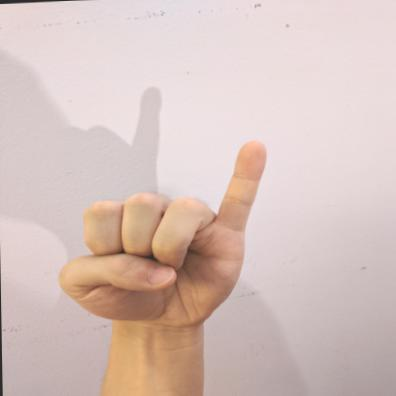

In [ ]:
image = ex['image']
image

In [ ]:
labels = data['train'].features['label']
labels

ClassLabel(names=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], id=None)

In [ ]:
labels.int2str(ex['label'])

'I'

## Fine-tuning a model on an image classification task

n models on the Indian Food dataset.


Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-15-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The `dataset` object itself is a DatasetDict, which contains one key per split (in this case, only "train" for a training split).

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1468
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 260
    })
})

Another prepatory step is to create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [ ]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

### Preprocessing the data

In [ ]:
model_name_or_path = 'microsoft/swin-tiny-patch4-window7-224'
from transformers import ViTImageProcessor

image_processor  = ViTImageProcessor.from_pretrained(model_name_or_path)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Before we can feed these images to our model, we need to preprocess them.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `torchvision.transforms` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), [Kornia](https://kornia.readthedocs.io/en/latest/) etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for inference.

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [ ]:
# split up training into training + validation
train_ds = data['train']
val_ds = data['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=396x396>,
 'label': 3,
 'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -0.4911, -0.4739, -0.4739],
          [-2.1179, -2.1179, -2.1179,  ..., -0.4911, -0.4739, -0.4739],
          [-2.1179, -2.1179, -2.1179,  ..., -0.5082, -0.4911, -0.4911],
          ...,
          [-0.2684, -0.3027, -0.3369,  ...,  0.5707,  0.5536,  0.5536],
          [-0.3883, -0.4226, -0.4568,  ...,  0.5878,  0.5707,  0.5536],
          [-0.4568, -0.4739, -0.4911,  ...,  0.5536,  0.5364,  0.5364]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -0.6877, -0.6702, -0.6702],
          [-2.0357, -2.0357, -2.0357,  ..., -0.6877, -0.6702, -0.6702],
          [-2.0357, -2.0357, -2.0357,  ..., -0.6702, -0.6702, -0.6702],
          ...,
          [-0.6352, -0.6702, -0.7227,  ..., -0.0049, -0.0224, -0.0224],
          [-0.7752, -0.8102, -0.8452,  ...,  0.0126, -0.0049, -0.0224],
          [-0.8803, -0.8978, -0.9153,  ...,  0.0126, -0.0049, -0.0399]]

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).


In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
     label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([26]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([26, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [ ]:
from transformers import TrainingArguments

model_name = model_name_or_path.split("/")[-1]

training_args = TrainingArguments(
    f'{model_name}-finetuned_ASL_Isolated_Swin_dataset2',
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=50,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    hub_strategy="end"
)#

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.


Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

You might wonder why we pass along the `feature_extractor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,1.560300,1.093140,0.642308
200,0.905500,0.506906,0.861538
300,0.425400,0.563384,0.815385
400,0.581400,0.288276,0.915385
500,0.495300,0.271004,0.915385
600,0.445600,0.245086,0.934615
700,0.452400,0.262464,0.930769
800,0.309500,0.239669,0.946154
900,0.322400,0.178664,0.938462
1000,0.406900,0.337578,0.923077


pytorch_model.bin:   0%|          | 0.00/110M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'ASL_Isolated_Swin_dataset',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("nandyc/ASL_Isolated_Swin_dataset")
model = AutoModelForImageClassification.from_pretrained("nandyc/ASL_Isolated_Swin_dataset")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a image of XYZ and see how the model does.

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "nandyc/swin-tiny-patch4-window7-224-finetuned_ASL_Isolated_Swin_dataset2"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


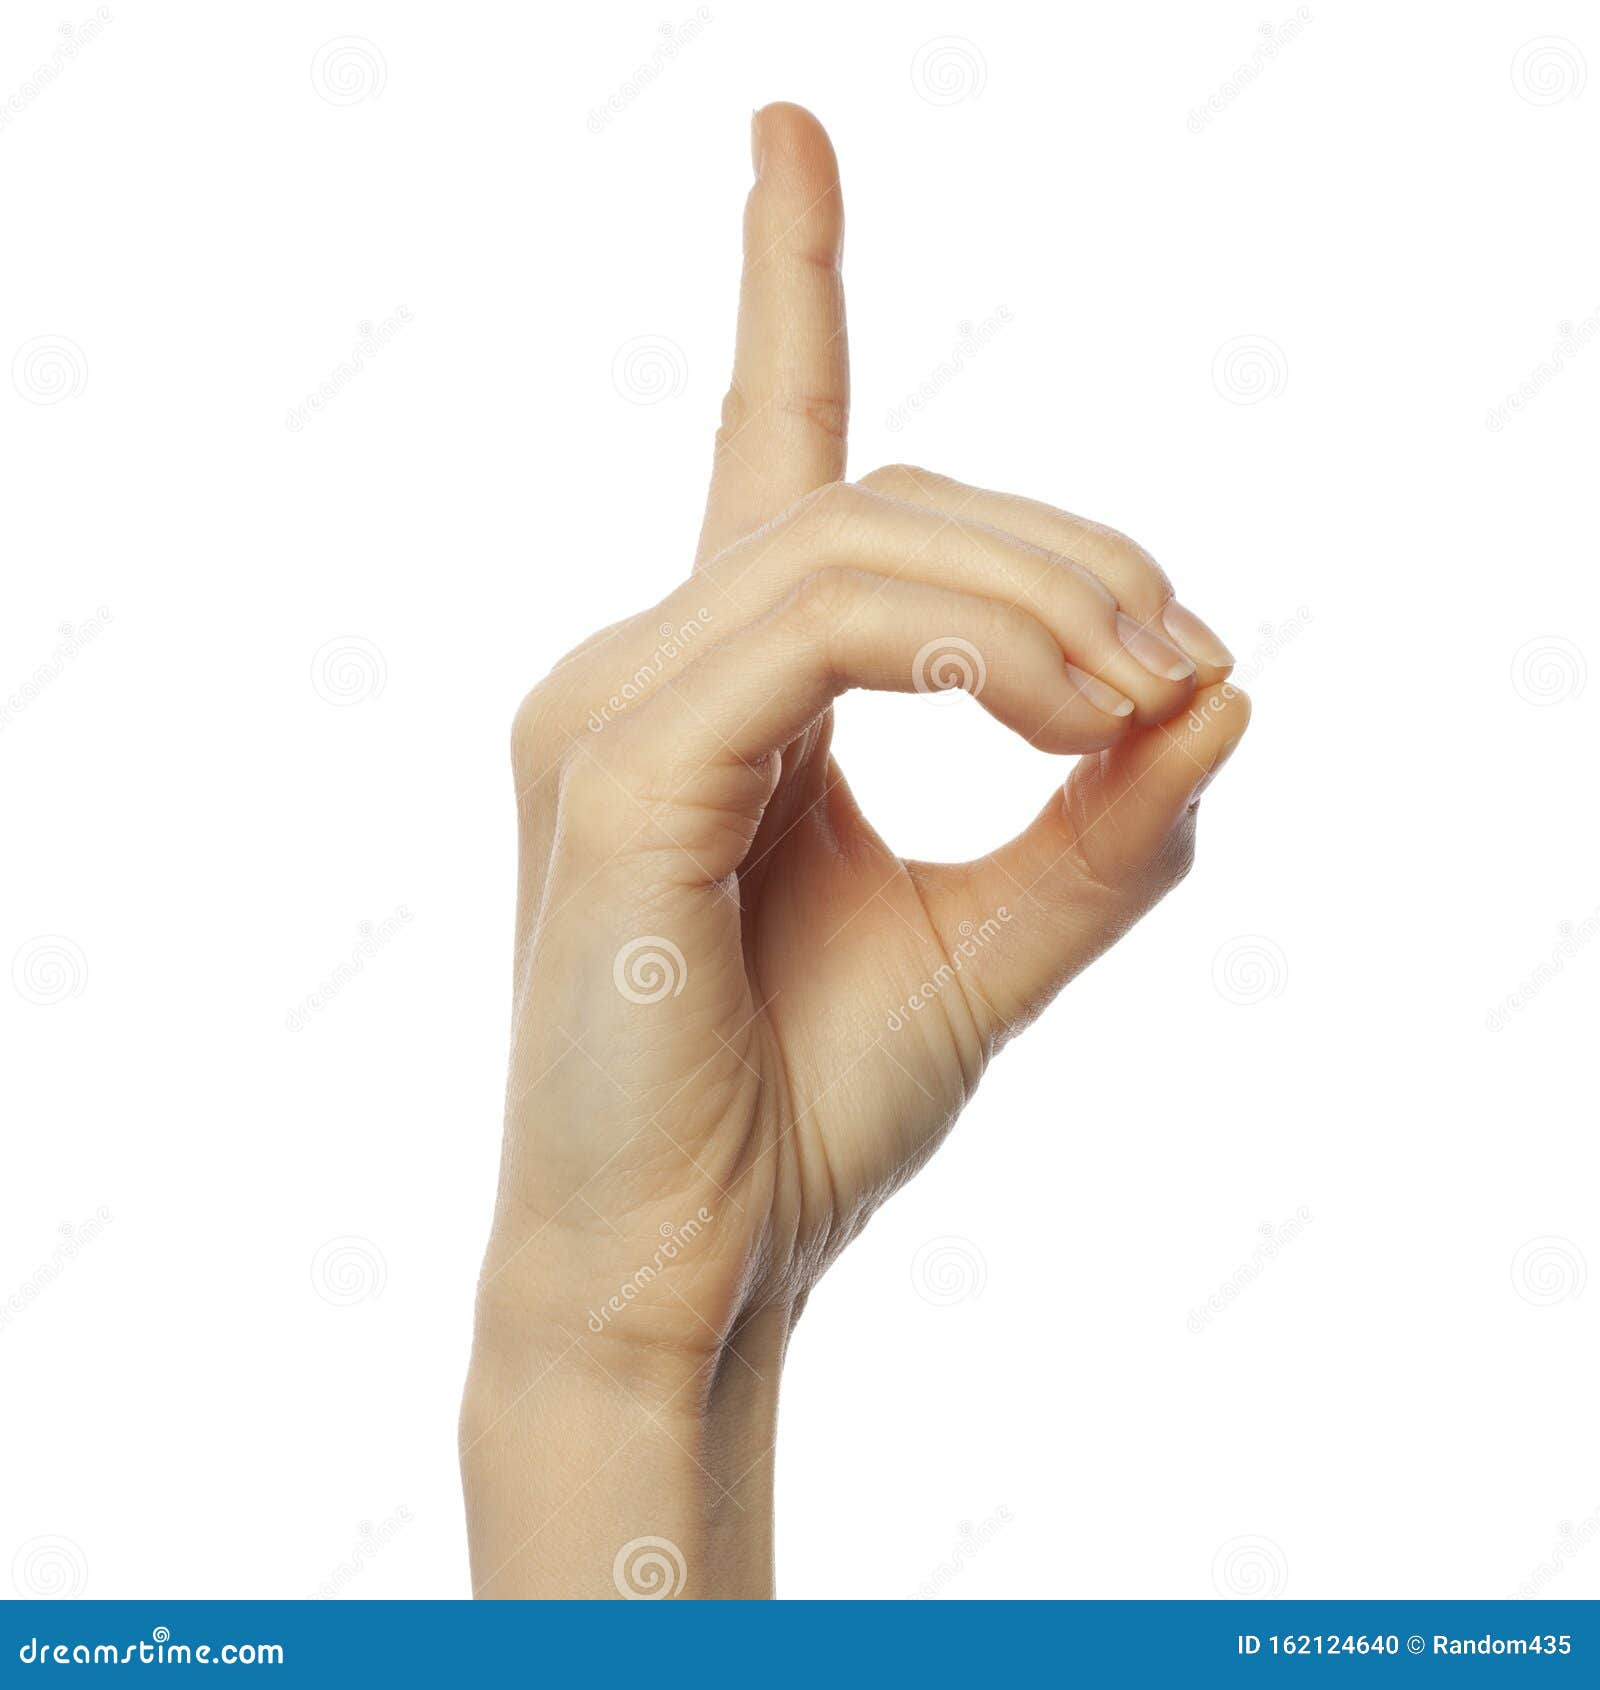

In [ ]:
from PIL import Image
import requests

# url1 = 'https://i.ytimg.com/vi/JmaNtY4EZo4/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLAJYp7ifniKu3UCgI_v2lH51ppVJg'
url1 = 'https://thumbs.dreamstime.com/z/finger-spelling-letter-d-american-sign-language-white-background-woman-showing-letter-d-isolated-white-asl-concept-finger-162124640.jpg'
image1 = Image.open(requests.get(url1, stream=True).raw)
image1

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
import torch
# prepare image for the model
encoding = feature_extractor(image1.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)


# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
from PIL import Image
import requests

# url1 = 'https://images2.pics4learning.com/catalog/d/d.jpg'
# image1 = Image.open(requests.get(url1, stream=True).raw)
testimage = "/content/a.jpg"
image1 = Image.open(testimage)
image1

import torch
# prepare image for the model
encoding = feature_extractor(image1.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)


# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits



In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Looks like our model got it correct!